# Binary Classification with the UCI Credit-card Default Dataset
_**Mitigating disparities in false-positive rates and false-negative rates**_

## Contents

1. [What is Covered](#What-is-Covered)
1. [Introduction](#Introduction)
1. [The UCI Credit-card Default Dataset](#The-UCI-Credit-card-Default-Dataset)
1. [Using a Fairness Unaware Model](#Using-a-Fairness-Unaware-Model)
1. [Mitigating Equalized Odds Difference with Postprocessing](#Mitigating-Equalized-Odds-Difference-with-Postprocessing)
1. [Mitigating Equalized Odds Difference with GridSearch](#Mitigating-Equalized-Odds-Difference-with-GridSearch)
1. [Conclusion](#Conclusion)

## What is Covered

* **Domain:**
  * Finance (loan decisions). The data is semisynthetic to create a simple example of disparities in FPR and FNR.

* **ML task:**
  * Binary classification.

* **Fairness tasks:**
  * Assessment of unfairness using Fairlearn metrics.
  * Mitigation of unfairness using Fairlearn mitigation algorithms.

* **Performance metrics:**
  * Area under ROC curve.
  * Balanced accuracy.

* **Fairness metrics:**
  * False-positive rate difference.
  * False-negative rate difference.
  * Equalized-odds difference.

* **Mitigation algorithms:**
  * `fairlearn.reductions.GridSearch`
  * `fairlearn.postprocessing.ThresholdOptimizer`

## Introduction

In this notebook, we consider a scenario where algorithmic tools are deployed to predict the likelihood that an applicant will default on a credit-card loan. The notebook emulates the problem presented in this [white paper](https://www.microsoft.com/en-us/research/uploads/prod/2020/09/Fairlearn-EY_WhitePaper-2020-09-22.pdf) in collaboration with EY.

Due to data privacy, we do not use the data from the white paper. Instead, we use the [UCI Credit-card default dataset](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients), a toy dataset reflecting credit-card defaults in Taiwan, as a substitute dataset to replicate the desired workflow. To make this dataset applicable to our problem, we introduce a synthethic feature that is highly predictive for applicants defined as "female" in terms of the "sex" feature, but is uninformative for applicants defined as "male".

We train a fairness-unaware algorithm on this dataset and show the model has a higher false-positive rate as well as a higher false-negative rate for the "male" group than for the "female" group. We then use Fairlearn to mitigate this disparity using both the `ThresholdOptimizer` and `GridSearch` algorithms.

In [12]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Data processing
from sklearn.model_selection import train_test_split

# Models
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV

# Fairlearn algorithms and utils
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import GridSearch, EqualizedOdds

# Metrics
from fairlearn.metrics import (
    MetricFrame, plot_model_comparison,
    selection_rate, demographic_parity_difference, demographic_parity_ratio,
    false_positive_rate, false_negative_rate,
    false_positive_rate_difference, false_negative_rate_difference,
    equalized_odds_difference)
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

## The UCI Credit-card Default Dataset

The UCI dataset contains data on 30,000 clients and their credit card transactions at a bank in Taiwan. In addition to static client features, the dataset contains the history of credit card bill payments between April and September 2005, as well as the balance limit of the client's credit card. The target is whether the client will default on a card payment in the following month, October 2005. A model trained on this data could be used, in part, to determine whether a client is eligible for another loan or a credit increase.

In [14]:
# Load the data
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
dataset = pd.read_excel(io=data_url, header=1).drop(columns=['ID']).rename(columns={'PAY_0':'PAY_1'})
dataset.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Dataset columns:

* `LIMIT_BAL`: credit card limit, will be replaced by a synthetic feature
* `SEX, EDUCATION, MARRIAGE, AGE`: client demographic features
* `BILL_AMT[1-6]`: amount on bill statement for April-September
* `PAY_AMT[1-6]`: payment amount for April-September
* `default payment next month`: target, whether the client defaulted the following month

In [15]:
# Extract the sensitive feature
A = dataset["SEX"]
A_str = A.map({ 2:"female", 1:"male"})
# Extract the target
Y = dataset["default payment next month"]
categorical_features = ['EDUCATION', 'MARRIAGE','PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
for col in categorical_features:
    dataset[col] = dataset[col].astype('category')

### Introduce a Synthetic Feature

We manipulate the balance-limit feature `LIMIT_BAL` to make it highly predictive for the "female" group but not for the "male" group. Specifically, we set this up, so that a lower credit limit indicates that a female client is less likely to default, but provides no information on a male client's probability of default.

In [16]:
dist_scale = 0.5
np.random.seed(12345)
# Make 'LIMIT_BAL' informative of the target
dataset['LIMIT_BAL'] = Y + np.random.normal(scale=dist_scale, size=dataset.shape[0])
# But then make it uninformative for the male clients
dataset.loc[A==1, 'LIMIT_BAL'] = np.random.normal(scale=dist_scale, size=dataset[A==1].shape[0])

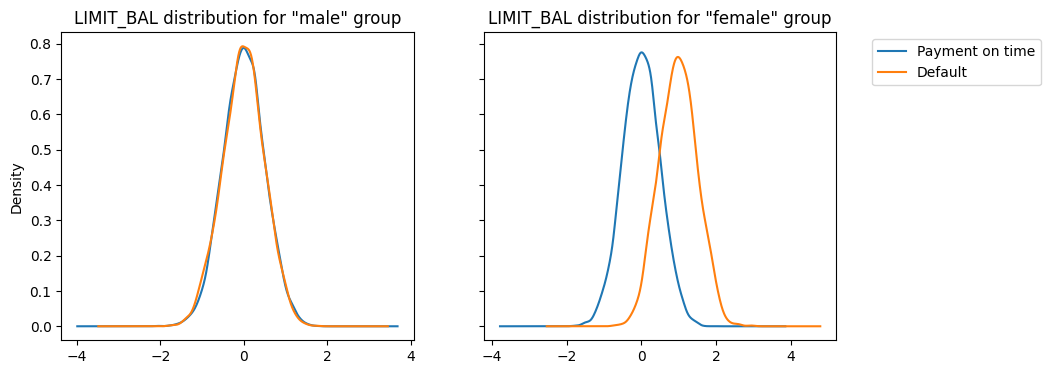

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
# Plot distribution of LIMIT_BAL for men
dataset['LIMIT_BAL'][(A==1) & (Y==0)].plot(kind='kde', label="Payment on time", ax=ax1, 
                                           title="LIMIT_BAL distribution for \"male\" group")
dataset['LIMIT_BAL'][(A==1) & (Y==1)].plot(kind='kde', label="Default", ax=ax1)
# Plot distribution of LIMIT_BAL for women
dataset['LIMIT_BAL'][(A==2) & (Y==0)].plot(kind='kde', label="Payment on time", ax=ax2, 
                                           legend=True, title="LIMIT_BAL distribution for \"female\" group")
dataset['LIMIT_BAL'][(A==2) & (Y==1)].plot(kind='kde', label="Default", ax=ax2, 
                                           legend=True).legend(bbox_to_anchor=(1.6, 1))
plt.show()

Note in the above figures that the new `LIMIT_BAL` feature is indeed highly predictive for the "female" group, but not for the "male" group.

In [18]:
# Train-test split
df_train, df_test, Y_train, Y_test, A_train, A_test, A_str_train, A_str_test = train_test_split(
    dataset.drop(columns=['SEX', 'default payment next month']), 
    Y, 
    A, 
    A_str,
    test_size = 0.3, 
    random_state=12345,
    stratify=Y)

## Using a Fairness Unaware Model

We train an out-of-the-box `lightgbm` model on the modified data and assess several fairness metrics. 

In [19]:
lgb_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'learning_rate': 0.03,
    'num_leaves' : 10,
    'max_depth' : 3
}

In [20]:
model = lgb.LGBMClassifier(**lgb_params)

In [21]:
model.fit(df_train, Y_train)

LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary')

In [22]:
# Scores on test set
test_scores = model.predict_proba(df_test)[:, 1]

In [23]:
# Train AUC
roc_auc_score(Y_train, model.predict_proba(df_train)[:, 1])

0.8500200312035275

In [24]:
# Predictions (0 or 1) on test set
test_preds = (test_scores >= np.mean(Y_train)) * 1

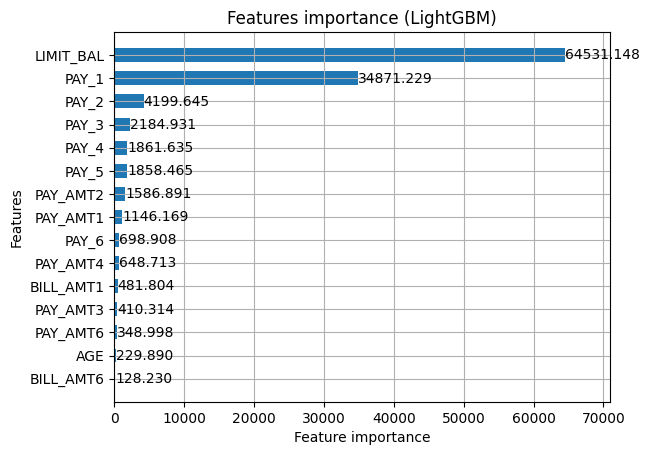

In [25]:
# LightGBM feature importance 
lgb.plot_importance(model, height=0.6, title="Features importance (LightGBM)", importance_type="gain", max_num_features=15) 
plt.show()

We notice that the synthetic feature `LIMIT_BAL` appears as the most important feature in this model although it has no predictive power for an entire demographic segment in the data.

We next use Fairlearn's `MetricFrame` to examine the the two different kinds of errors (false positives and false negatives) on the test data.

In [26]:
mf = MetricFrame({
    'FPR': false_positive_rate,
    'FNR': false_negative_rate},
    Y_test, test_preds, sensitive_features=A_str_test)

mf.by_group

c:\Users\Pikachu\AppData\Local\Programs\Python\Python310\lib\site-packages\fairlearn\metrics\_metric_frame.py:70: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(


,FPR,FNR
SEX,,
female,0.141026,0.151224
male,0.150322,0.493506


Note that both kinds of errors are more common in the "male" group than in the "female" group.

In [27]:
# Helper functions
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Overall selection rate": (
            lambda x: selection_rate(y_true, x), True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
        "Demographic parity ratio": (
            lambda x: demographic_parity_ratio(y_true, x, sensitive_features=group), True),
        "------": (lambda x: "", True),
        "Overall balanced error rate": (
            lambda x: 1-balanced_accuracy_score(y_true, x), True),
        "Balanced error rate difference": (
            lambda x: MetricFrame(metrics=balanced_accuracy_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), True),
        " ------": (lambda x: "", True),
        "False positive rate difference": (
            lambda x: false_positive_rate_difference(y_true, x, sensitive_features=group), True),
        "False negative rate difference": (
            lambda x: false_negative_rate_difference(y_true, x, sensitive_features=group), True),
        "Equalized odds difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "  ------": (lambda x: "", True),
        "Overall AUC": (
            lambda x: roc_auc_score(y_true, x), False),
        "AUC difference": (
            lambda x: MetricFrame(metrics=roc_auc_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), False),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

We calculate several performance and fairness metrics below:

In [28]:
# Metrics
models_dict = {"Unmitigated": (test_preds, test_scores)}
get_metrics_df(models_dict, Y_test, A_str_test)

,Unmitigated
Overall selection rate,0.268111
Demographic parity difference,0.051105
Demographic parity ratio,0.8225
------,
Overall balanced error rate,0.220682
Balanced error rate difference,0.175789
------,
False positive rate difference,0.009296
False negative rate difference,0.342283
Equalized odds difference,0.342283


As the overall performance metric we use the _area under ROC curve_ (AUC), which is suited to classification problems with a large imbalance between positive and negative examples. For binary classifiers, this is the same as _balanced accuracy_.

As the fairness metric we use *equalized odds difference*, which quantifies the disparity in accuracy experienced by different demographics. Our goal is to assure that neither of the two groups ("male" vs "female") has substantially larger false-positive rates or false-negative rates than the other group. The equalized odds difference is equal to the larger of the following two numbers: (1) the difference between false-positive rates of the two groups, (2) the difference between false-negative rates of the two groups.

The table above shows the overall AUC of 0.85 (based on continuous predictions) and the overall balanced error rate of 0.22 (based on 0/1 predictions). Both of these are satisfactory in our application context. However, there is a large disparity in accuracy rates (as indicated by the balanced error rate difference) and even larger when we consider the equalized-odds difference. As a sanity check, we also show the demographic parity ratio, whose level (slightly above 0.8) is considered satisfactory in this context.

## Mitigating Equalized Odds Difference with Postprocessing

We attempt to mitigate the disparities in the `lightgbm` predictions using the Fairlearn postprocessing algorithm `ThresholdOptimizer`. This algorithm finds a suitable threshold for the scores (class probabilities) produced by the `lightgbm` model by optimizing the accuracy rate under the constraint that the equalized odds difference (on training data) is zero. Since our goal is to optimize balanced accuracy, we resample the training data to have the same number of positive and negative examples. This means that `ThresholdOptimizer` is effectively optimizing balanced accuracy on the original data.

In [29]:
postprocess_est = ThresholdOptimizer(
    estimator=model,
    constraints="equalized_odds",
    prefit=True)

In [30]:
# Balanced data set is obtained by sampling the same number of points from the majority class (Y=0)
# as there are points in the minority class (Y=1)
balanced_idx1 = df_train[Y_train==1].index
pp_train_idx = balanced_idx1.union(Y_train[Y_train==0].sample(n=balanced_idx1.size, random_state=1234).index)

In [31]:
df_train_balanced = df_train.loc[pp_train_idx, :]
Y_train_balanced = Y_train.loc[pp_train_idx]
A_train_balanced = A_train.loc[pp_train_idx]

In [32]:
postprocess_est.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)

c:\Users\Pikachu\AppData\Local\Programs\Python\Python310\lib\site-packages\fairlearn\postprocessing\_threshold_optimizer.py:285: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(


ThresholdOptimizer(constraints='equalized_odds',
                   estimator=LGBMClassifier(learning_rate=0.03, max_depth=3,
                                            metric='auc', num_leaves=10,
                                            objective='binary'),
                   prefit=True)

In [33]:
postprocess_preds = postprocess_est.predict(df_test, sensitive_features=A_test)

In [34]:
models_dict = {"Unmitigated": (test_preds, test_scores),
              "ThresholdOptimizer": (postprocess_preds, postprocess_preds)}
get_metrics_df(models_dict, Y_test, A_str_test)

,Unmitigated,ThresholdOptimizer
Overall selection rate,0.268111,0.080778
Demographic parity difference,0.051105,0.005265
Demographic parity ratio,0.8225,0.937323
------,,
Overall balanced error rate,0.220682,0.406107
Balanced error rate difference,0.175789,0.007486
------,,
False positive rate difference,0.009296,0.002053
False negative rate difference,0.342283,0.012919
Equalized odds difference,0.342283,0.012919


The `ThresholdOptimizer` algorithm significantly reduces the disparity according to multiple metrics. However, the performance metrics (balanced error rate as well as AUC) get worse. Before deploying such a model in practice, it would be important to examine in more detail why we observe such a sharp trade-off. In our case it is because the available features are much less informative for one of the demographic groups than for the other.

Note that unlike the unmitigated model, `ThresholdOptimizer` produces 0/1 predictions, so its balanced error rate difference is equal to the AUC difference, and its overall balanced error rate is equal to 1 - overall AUC.

## Mitigating Equalized Odds Difference with GridSearch

We now attempt to mitigate disparities using the `GridSearch` algorithm. Unlike `ThresholdOptimizer`, the predictors produced by `GridSearch` do not access the sensitive feature at test time. Also, rather than training a single model, we train multiple models corresponding to different trade-off points between the performance metric (balanced accuracy) and fairness metric (equalized odds difference).

In [35]:
# Train GridSearch
sweep = GridSearch(model,
                   constraints=EqualizedOdds(),
                   grid_size=50,
                   grid_limit=3)

sweep.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)

In [36]:
sweep_preds = [predictor.predict(df_test) for predictor in sweep.predictors_] 
sweep_scores = [predictor.predict_proba(df_test)[:, 1] for predictor in sweep.predictors_] 

In [37]:
equalized_odds_sweep = [
    equalized_odds_difference(Y_test, preds, sensitive_features=A_str_test)
    for preds in sweep_preds
]
balanced_accuracy_sweep = [balanced_accuracy_score(Y_test, preds) for preds in sweep_preds]
auc_sweep = [roc_auc_score(Y_test, scores) for scores in sweep_scores]

In [38]:
# Select only non-dominated models (with respect to balanced accuracy and equalized odds difference)
all_results = pd.DataFrame(
    {"predictor": sweep.predictors_, "accuracy": balanced_accuracy_sweep, "disparity": equalized_odds_sweep}
) 
non_dominated = [] 
for row in all_results.itertuples(): 
    accuracy_for_lower_or_eq_disparity = all_results["accuracy"][all_results["disparity"] <= row.disparity] 
    if row.accuracy >= accuracy_for_lower_or_eq_disparity.max(): 
        non_dominated.append(True)
    else:
        non_dominated.append(False)

equalized_odds_sweep_non_dominated = np.asarray(equalized_odds_sweep)[non_dominated]
balanced_accuracy_non_dominated = np.asarray(balanced_accuracy_sweep)[non_dominated]
auc_non_dominated = np.asarray(auc_sweep)[non_dominated]

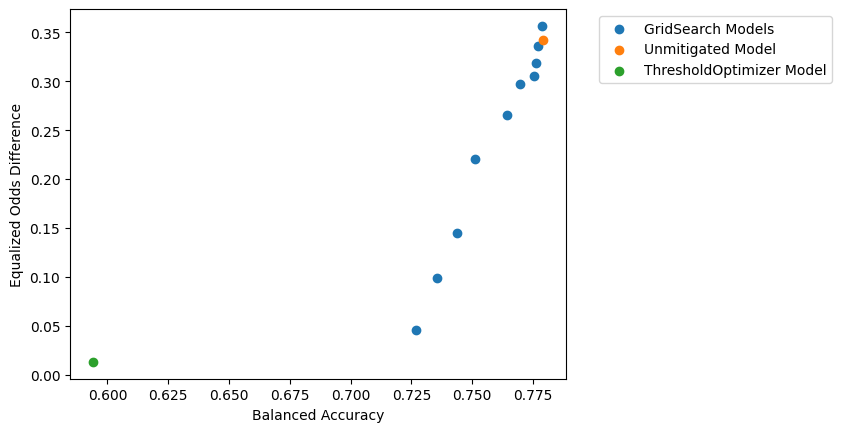

In [39]:
# Plot equalized odds difference vs balanced accuracy
plt.scatter(balanced_accuracy_non_dominated, equalized_odds_sweep_non_dominated, label="GridSearch Models")
plt.scatter(balanced_accuracy_score(Y_test, test_preds),
            equalized_odds_difference(Y_test, test_preds, sensitive_features=A_str_test), 
            label="Unmitigated Model")
plt.scatter(balanced_accuracy_score(Y_test, postprocess_preds), 
            equalized_odds_difference(Y_test, postprocess_preds, sensitive_features=A_str_test),
            label="ThresholdOptimizer Model")
plt.xlabel("Balanced Accuracy")
plt.ylabel("Equalized Odds Difference")
plt.legend(bbox_to_anchor=(1.55, 1))
plt.show()

As intended, `GridSearch` models appear along the trade-off curve between the large balanced accuracy (but also large disparity), and low disparity (but worse balanced accuracy). This gives the data scientist a flexibility to select a model that fits the application context best.

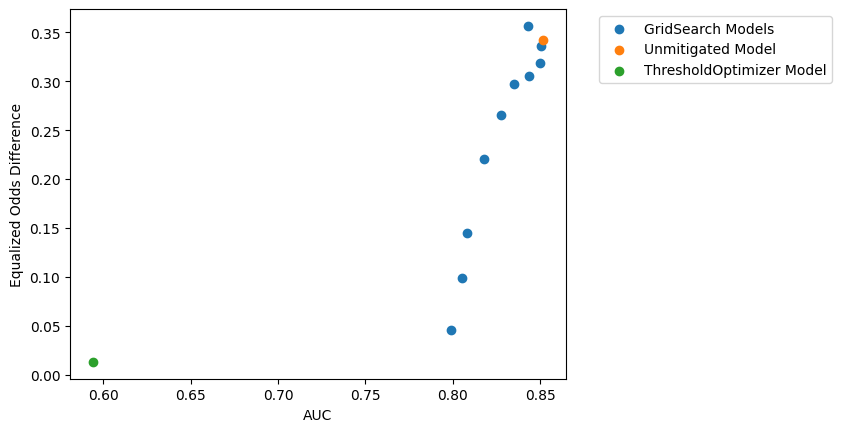

In [40]:
# Plot equalized odds difference vs AUC
plt.scatter(auc_non_dominated, equalized_odds_sweep_non_dominated, label="GridSearch Models")
plt.scatter(roc_auc_score(Y_test, test_scores),
            equalized_odds_difference(Y_test, test_preds, sensitive_features=A_str_test), 
            label="Unmitigated Model")
plt.scatter(roc_auc_score(Y_test, postprocess_preds), 
            equalized_odds_difference(Y_test, postprocess_preds, sensitive_features=A_str_test),
            label="ThresholdOptimizer Model")
plt.xlabel("AUC")
plt.ylabel("Equalized Odds Difference")
plt.legend(bbox_to_anchor=(1.55, 1))
plt.show()

Similarly, `GridSearch` models appear along the trade-off curve between AUC and equalized odds difference.

In [41]:
# Compare GridSearch models with low values of equalized odds difference with the previously constructed models
grid_search_dict = {"GridSearch_{}".format(i): (sweep_preds[i], sweep_scores[i])
                    for i in range(len(sweep_preds))
                    if non_dominated[i] and equalized_odds_sweep[i]<0.1}
models_dict.update(grid_search_dict)
get_metrics_df(models_dict, Y_test, A_str_test)

,Unmitigated,ThresholdOptimizer,GridSearch_39,GridSearch_40
Overall selection rate,0.268111,0.080778,0.268667,0.256
Demographic parity difference,0.051105,0.005265,0.020546,0.03327
Demographic parity ratio,0.8225,0.937323,0.926947,0.87962
------,,,,
Overall balanced error rate,0.220682,0.406107,0.264572,0.273208
Balanced error rate difference,0.175789,0.007486,0.066646,0.040527
------,,,,
False positive rate difference,0.009296,0.002053,0.034358,0.035793
False negative rate difference,0.342283,0.012919,0.098935,0.045262
Equalized odds difference,0.342283,0.012919,0.098935,0.045262


## Conclusion

In this notebook, we explored how a fairness-unaware gradient boosted trees model performed on the classification task in contrast to the postprocessed `ThresholdOptimizer` model and the `GridSearch` model. The `ThresholdOptimizer` greatly reduced the disparity in performance across multiple fairness metrics. However the overall error rate and AUC for the `ThresholdOptimizer` model were worse compared to the fairness-unaware model. 

With the `GridSearch` algorithm, we trained multiple models that balance the trade-off between the balanced accuracy and the equalized odds fairness metric. After engaging with relevant stakeholders, the data scientist can deploy the model that balances the performance-fairness trade-off that meets the needs of the business.